In [10]:
#Prepare the necessary data and packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

df=pd.read_csv(r'C:\Users\dkond\Desktop\kc_house_data.csv',index_col='id')
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [11]:
pd.Series(df.index.duplicated()).value_counts()

#Duplicates will be kept, considering there are so few and a house may reasonably have been sold twice in this timeframe

False    21420
True       177
dtype: int64

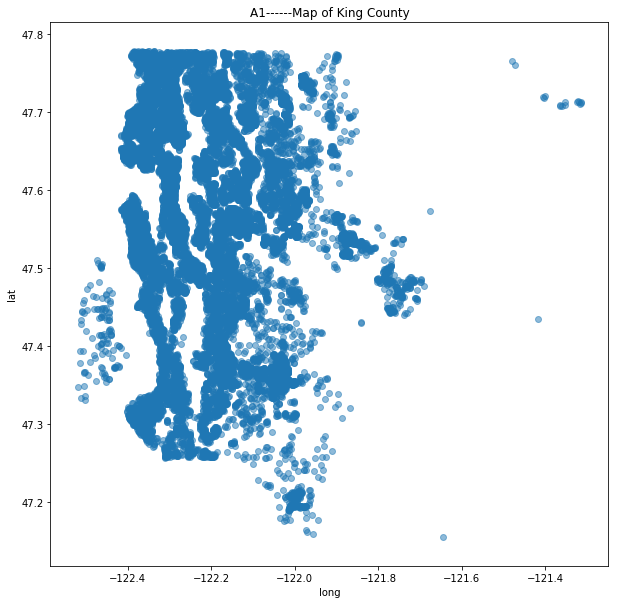

In [12]:
data=df.drop(['lat','long'],axis=1)
#lat and long are unneccessary with the zipcode

# Q1 ------- What does King County look like on a map
plt.figure(figsize=(10,10))
plt.scatter(df.long,df.lat,alpha=.5)
plt.xlabel('long')
plt.ylabel('lat')
plt.title('A1------Map of King County')
plt.show()

In [13]:
#Q2------ Is the month sold an important statistic? We'll find out during linear regression analysis!

data['month']=[int(x.split('/')[0]) for x in df.date]
#It is incredibly unlikely that there is a difference in price between 2014 and 2015
data.drop('date',axis=1,inplace=True)

               bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
bedrooms       1.000000   0.514508     0.578212  0.032471  0.177944   
bathrooms      0.514508   1.000000     0.755758  0.088373  0.502582   
sqft_living    0.578212   0.755758     1.000000  0.173453  0.353953   
sqft_lot       0.032471   0.088373     0.173453  1.000000 -0.004814   
floors         0.177944   0.502582     0.353953 -0.004814  1.000000   
waterfront    -0.002386   0.067282     0.110230  0.023143  0.021883   
view           0.078523   0.186451     0.282532  0.075298  0.028436   
condition      0.026496  -0.126479    -0.059445 -0.008830 -0.264075   
grade          0.356563   0.665838     0.762779  0.114731  0.458794   
sqft_above     0.479386   0.686668     0.876448  0.184139  0.523989   
yr_built       0.155670   0.507173     0.318152  0.052946  0.489193   
yr_renovated   0.018495   0.051050     0.055660  0.004513  0.003535   
zipcode       -0.154092  -0.204786    -0.199802 -0.129586 -0.059541   
sqft_l

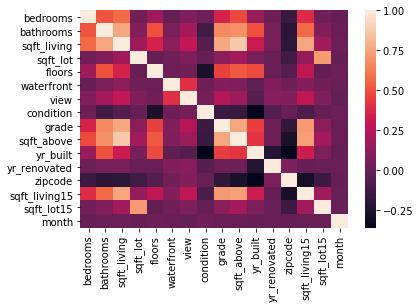

In [14]:
predictors=data.drop('price',axis=1)   
target=data.price

#Find the correlations between the predictors, drop any that appear to be too closely correlated 

sns.heatmap(predictors.corr())
print(predictors.corr())              
predictors=predictors.drop(['bathrooms','grade','sqft_lot15','sqft_above','sqft_living15'],axis=1)


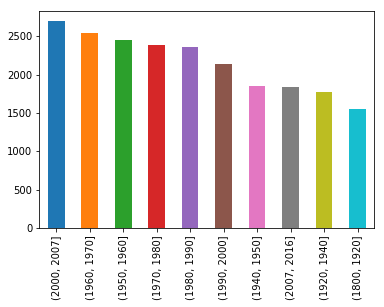

In [15]:
predictors.columns

#Create dummies for all the categorical variables

bedroom_dummies=pd.get_dummies(data.bedrooms,prefix='bed',drop_first=True)
floors_dummies=pd.get_dummies(data.floors,prefix='floors',drop_first=True)
condition_dummies=pd.get_dummies(data.condition,prefix='condition',drop_first=True)
month_dummies=pd.get_dummies(data.month,prefix='month',drop_first=True)
zipcode_dummies=pd.get_dummies(data.zipcode,prefix='zipcode',drop_first=True)

predictors.drop(['bedrooms','floors','condition','month','zipcode'],axis=1,inplace=True)
predictors=pd.concat([predictors,bedroom_dummies,floors_dummies,condition_dummies,month_dummies,zipcode_dummies],axis=1)

#Yr_built is also a categorical variable that should be binned

bins=[1800,1920,1940,1950,1960,1970,1980,1990,2000,2007,2016]
yr_built_bins=pd.cut(predictors.yr_built,bins).cat.as_ordered()
yr_built_bins.value_counts().plot(kind='bar')
plt.show()
predictors['yr_built']=yr_built_bins

predictors.yr_built.cat.codes
yr_dummies=pd.get_dummies(yr_built_bins,prefix='year',drop_first=True)
predictors=predictors.drop('yr_built',axis=1)
predictors=pd.concat([predictors,yr_dummies],axis=1)



In [18]:
waterfront_dummies=pd.get_dummies(predictors.waterfront,prefix='waterfront',drop_first=True)
view_dummies=pd.get_dummies(predictors.view,prefix='view',drop_first=True)


predictors.drop(['waterfront','yr_renovated','view'],axis=1,inplace=True)
predictors=pd.concat([predictors,waterfront_dummies,view_dummies],axis=1)
predictors.head()



,sqft_living,sqft_lot,sqft_basement,bed_2,bed_3,bed_4,bed_5,bed_6,bed_7,bed_8,...,"year_(1970, 1980]","year_(1980, 1990]","year_(1990, 2000]","year_(2000, 2007]","year_(2007, 2016]",waterfront_1.0,view_1.0,view_2.0,view_3.0,view_4.0
id,,,,,,,,,,,,,,,,,,,,,
7129300520,1180,5650,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6414100192,2570,7242,400.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5631500400,770,10000,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2487200875,1960,5000,910.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1954400510,1680,8080,0.0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


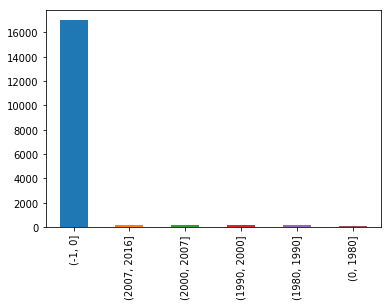

In [19]:
bins=[-1,0,1980,1990,2000,2007,2016]
renovated_bins=pd.cut(df.yr_renovated,bins).cat.as_ordered()
renovated_bins.value_counts().plot(kind='bar')

predictors['yr_renovated']=renovated_bins

predictors.yr_renovated.cat.codes
renovated_dummies=pd.get_dummies(renovated_bins,prefix='renovated',drop_first=True)
predictors=predictors.drop('yr_renovated',axis=1)
predictors=pd.concat([predictors,renovated_dummies],axis=1)


In [20]:
#Normalize the remaining continuous variables
predictors.sqft_basement.replace('?','0.0',inplace=True)
predictors.sqft_basement.value_counts()
predictors.sqft_basement=[int(x.split('.')[0]) for x in predictors.sqft_basement]

C:\Users\dkond\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


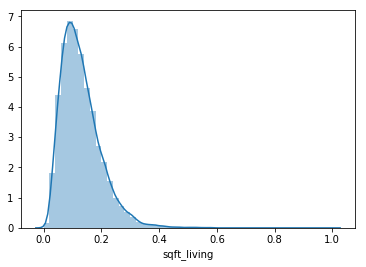

C:\Users\dkond\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


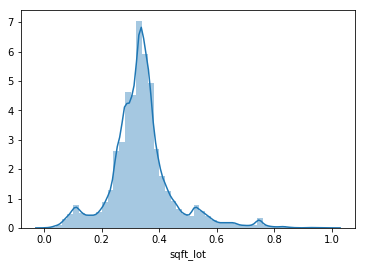

C:\Users\dkond\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


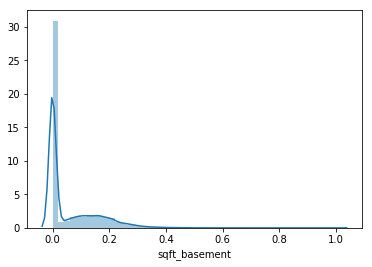

In [41]:
def MinNormalize(data):
    Max=data.max()
    Min=data.min()
    return (data-Min)/(Max-Min)


predictors.sqft_lot=np.log(predictors.sqft_lot)
predictors.sqft_basement=MinNormalize(predictors.sqft_basement)
predictors.sqft_lot=MinNormalize(predictors.sqft_lot)
predictors.sqft_living=MinNormalize(predictors.sqft_living)



tempdf=predictors[['sqft_living','sqft_lot','sqft_basement']]
for col in tempdf:
    sns.distplot(tempdf[col])
    plt.show()
    


In [42]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included



C:\Users\dkond\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


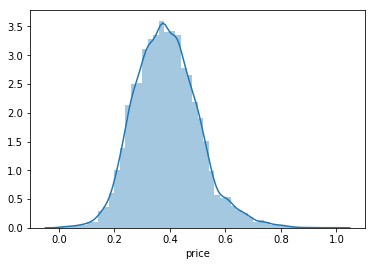

In [51]:
target=np.log(target)
target=MinNormalize(target)
sns.distplot(target)

In [52]:
results=stepwise_selection(predictors,target)

Add  floors_2.0                     with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  sqft_living                    with p-value 0.0
Drop floors_2.0                     with p-value 0.168717


C:\Users\dkond\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  zipcode_98004                  with p-value 3.87441e-202
Add  zipcode_98023                  with p-value 1.22423e-201
Add  zipcode_98042                  with p-value 2.56063e-162
Add  zipcode_98112                  with p-value 2.3243e-148
Drop sqft_basement                  with p-value 0.224289
Add  view_4.0                       with p-value 5.67685e-132
Add  zipcode_98103                  with p-value 7.61128e-129
Add  zipcode_98115                  with p-value 1.0657e-124
Add  zipcode_98117                  with p-value 1.50692e-125
Add  zipcode_98040                  with p-value 4.75551e-132
Add  zipcode_98199                  with p-value 6.94542e-135
Add  zipcode_98105                  with p-value 2.99018e-137
Add  zipcode_98119                  with p-value 5.8269e-141
Add  zipcode_98033                  with p-value 9.34762e-145
Add  zipcode_98107                  with p-value 7.87488e-119
Add  zipcode_98122                  with p-value 2.21275e-124
Add  zipcode_98

In [55]:
#A2-------Month sold barely matters

print('These are the columns we are using\n\n',results)
print('\n\nThese are the columns we are excluding\n\n',set(predictors.columns)-set(results))

These are the columns we are using

 ['sqft_living', 'zipcode_98004', 'zipcode_98023', 'zipcode_98112', 'view_4.0', 'zipcode_98103', 'zipcode_98115', 'zipcode_98117', 'zipcode_98040', 'zipcode_98199', 'zipcode_98105', 'zipcode_98119', 'zipcode_98033', 'zipcode_98107', 'zipcode_98122', 'zipcode_98109', 'zipcode_98116', 'zipcode_98052', 'zipcode_98006', 'zipcode_98039', 'zipcode_98102', 'zipcode_98002', 'zipcode_98022', 'sqft_basement', 'view_3.0', 'view_2.0', 'zipcode_98005', 'waterfront_1.0', 'zipcode_98008', 'zipcode_98136', 'zipcode_98144', 'sqft_lot', 'zipcode_98029', 'zipcode_98074', 'zipcode_98075', 'zipcode_98053', 'zipcode_98007', 'zipcode_98034', 'zipcode_98177', 'zipcode_98125', 'zipcode_98027', 'zipcode_98126', 'month_4', 'condition_5', 'year_(2007, 2016]', 'zipcode_98072', 'view_1.0', 'zipcode_98133', 'zipcode_98118', 'condition_2', 'zipcode_98077', 'zipcode_98011', 'zipcode_98155', 'zipcode_98028', 'zipcode_98065', 'zipcode_98059', 'month_3', 'renovated_(2007, 2016]', 'cond

In [57]:
BestPredictors=predictors[results]


predictors_int = sm.add_constant(BestPredictors)
model = sm.OLS(target,predictors_int).fit()
model.summary()

#Certain zipcodes have a negative coefficient, implying they are "bad neighborhoods" that lower the value of a house
#Higher numbers of beds also have negative coefficients, unsure why, possibly because it means lots of college students
#    would need to share the space???
#Zipcodes 98007 and 98177 have huge coefficients, implying they are prime real estate

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1427.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:38:40   Log-Likelihood:                 38082.
No. Observations:               21597   AIC:                        -7.596e+04
Df Residuals:                   21496   BIC:                        -7.516e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0300      0.008      3.747      0.000       0.014       0.046
sqft_living                0.8651      0.007    124.581      0.000       0.851       0.879
zipcode_98004              0.2568      0.003    100.296      0.000       0.252       0.262
zipcode_98023             -0.0043      0.002     -2.052      0.040      -0.008      -0.000
zipcode_98112              0.2535      0.003     90.673      0.000       0.248       0.259
view_4.0                   0.0806      0.003     27.251      0.000       0.075       0.086
zipcode_98103              0.1908      0.002     91.585      0.000       0.187       0.195
zipcode_98115              0.1869      0.002     91.101      0.000       0.183       0.191
zipcode_98117              0.1840      0.002     87.861      0.000       0.180       0.188
zipcode_98040              0.2088      0.003     77.164      0.000       0.203       0.214
zipcode_98199              0.2048      0.003     78.564      0.000       0.200       0.210
zipcode_98105              0.2249      0.003     74.818      0.000       0.219       0.231
zipcode_98119              0.2343      0.003     71.336      0.000       0.228       0.241
zipcode_98033              0.1748      0.002     79.274      0.000       0.170       0.179
zipcode_98107              0.1973      0.003     70.138      0.000       0.192       0.203
zipcode_98122              0.1938      0.003     72.049      0.000       0.189       0.199
zipcode_98109              0.2369      0.004     56.917      0.000       0.229       0.245
zipcode_98116              0.1728      0.003     67.947      0.000       0.168       0.178
zipcode_98052              0.1479      0.002     75.120      0.000       0.144       0.152
zipcode_98006              0.1531      0.002     72.405      0.000       0.149       0.157
zipcode_98039              0.2869      0.006     47.748      0.000       0.275       0.299
zipcode_98102              0.2363      0.004     55.584      0.000       0.228       0.245
zipcode_98002             -0.0193      0.003     -6.241      0.000      -0.025      -0.013
zipcode_98022             -0.0090      0.003     -3.099      0.002      -0.015      -0.003
sqft_basement             -0.0896      0.004    -22.472      0.000      -0.097      -0.082
view_3.0                   0.0516      0.002     26.411      0.000       0.048       0.055
view_2.0                   0.0330      0.001     23.057      0.000       0.030       0.036
zipcode_98005              0.1794      0.003     53.356      0.000       0.173       0.186
waterfront_1.0             0.0888      0.004     20.734      0.000       0.080       0.097
zipcode_98008              0.1520      0.003     56.873      0.000       0.147       0.157
zipcode_98136              0.1532      0.003     55.022      0.000       0.148  

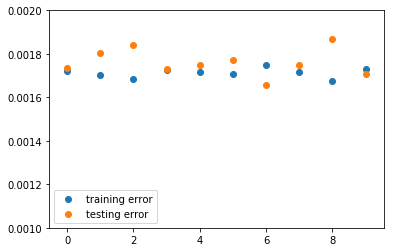

In [69]:
# Lets do some training/testing now
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
linreg=LinearRegression()


trainerror=[]
testerror=[]

for i in range(10):
    
    Xtrain,Xtest,ytrain,ytest=TTS(BestPredictors,target)
    linreg.fit(Xtrain,ytrain)

    yhattrain=linreg.predict(Xtrain)
    yhattest=linreg.predict(Xtest)
    
    trainerror.append(MSE(yhattrain,ytrain))
    testerror.append(MSE(yhattest,ytest))
    
plt.scatter(range(10),trainerror,label='training error')
plt.scatter(range(10),testerror,label='testing error')
plt.legend()
plt.ylim([.001,.002])
plt.show()

#testing and training errors are very near to one another

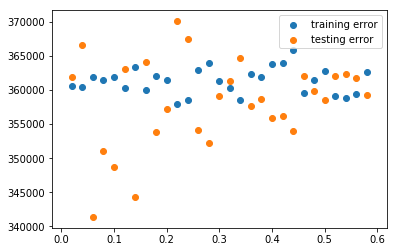

In [94]:
#Q3-----Does sqft_living correlate to sqft_living15?


X=df[['sqft_living15']]
y=df[['sqft_living']]

linreg=LinearRegression()


trainerror=[]
testerror=[]

Sizes=[i*.02 for i in range(1,30)]

for size in Sizes:
    TrainAvg=[]
    TestAvg=[]
    for i in range(10):
        Xtrain,Xtest,ytrain,ytest=TTS(X,y,test_size=size)
        linreg.fit(Xtrain,ytrain)

        yhattrain=linreg.predict(Xtrain)
        yhattest=linreg.predict(Xtest)

        TrainAvg.append(MSE(yhattrain,ytrain))
        TestAvg.append(MSE(yhattest,ytest))
        
    trainerror.append(sum(TrainAvg)/10)
    testerror.append(sum(TestAvg)/10)

plt.scatter(Sizes,trainerror,label='training error')
plt.scatter(Sizes,testerror,label='testing error')
plt.legend()
plt.show()
#A1-----it's pretty clear from this mess that theres no way we have a good correlation

In [95]:
predictors_int = sm.add_constant(X)
model = sm.OLS(y,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sqft_living   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                 2.888e+04
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        02:47:58   Log-Likelihood:            -1.6882e+05
No. Observations:               21597   AIC:                         3.376e+05
Df Residuals:                   21595   BIC:                         3.377e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            66.9523     12.533      5.342      0.000      42.387      91.518
sqft_living15     1.0135      0.006    169.934      0.000       1.002       1.025
==============================================================================
Omnibus:                     9124.101   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106346.077
Skew:                           1.710   Prob(JB):                         0.00
Kurtosis:                      13.319   Cond. No.                     6.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""